https://tbr74.tistory.com/entry/feature-importances-%ED%94%BC%EC%B3%90-%EC%A4%91%EC%9A%94%EB%8F%84

* 세계 나라기준 지도데이터(geo_data) <br>
https://github.com/amcharts/amcharts4-geodata/blob/master/dist/script/json/rwandaLow.json

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import googlemaps
from bs4 import BeautifulSoup
import folium 
from folium.plugins import MarkerCluster
from folium import Marker
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [4]:
trainset = train.drop(columns = 'ID_LAT_LON_YEAR_WEEK', axis = 1)
trainset.fillna(trainset.median(), inplace=True)

In [5]:
pd.set_option('display.max_columns', None) ## 모든 열을 출력한다.

In [6]:
trainset.shape

(79023, 75)

In [7]:
column_names = list(trainset.columns.values)    #print all columns name

In [8]:
column_names1 = list(trainset.columns)  #데이터프레임 컬럼이름 전체 출력
column_names1

['latitude',
 'longitude',
 'year',
 'week_no',
 'SulphurDioxide_SO2_column_number_density',
 'SulphurDioxide_SO2_column_number_density_amf',
 'SulphurDioxide_SO2_slant_column_number_density',
 'SulphurDioxide_cloud_fraction',
 'SulphurDioxide_sensor_azimuth_angle',
 'SulphurDioxide_sensor_zenith_angle',
 'SulphurDioxide_solar_azimuth_angle',
 'SulphurDioxide_solar_zenith_angle',
 'SulphurDioxide_SO2_column_number_density_15km',
 'CarbonMonoxide_CO_column_number_density',
 'CarbonMonoxide_H2O_column_number_density',
 'CarbonMonoxide_cloud_height',
 'CarbonMonoxide_sensor_altitude',
 'CarbonMonoxide_sensor_azimuth_angle',
 'CarbonMonoxide_sensor_zenith_angle',
 'CarbonMonoxide_solar_azimuth_angle',
 'CarbonMonoxide_solar_zenith_angle',
 'NitrogenDioxide_NO2_column_number_density',
 'NitrogenDioxide_tropospheric_NO2_column_number_density',
 'NitrogenDioxide_stratospheric_NO2_column_number_density',
 'NitrogenDioxide_NO2_slant_column_number_density',
 'NitrogenDioxide_tropopause_pressure'

In [9]:
top20_corrs = abs(train.corr()['emission']).sort_values(ascending = False).head(20)
top20_corrs

emission                                                    1.000000
longitude                                                   0.102746
UvAerosolLayerHeight_aerosol_height                         0.069008
UvAerosolLayerHeight_aerosol_pressure                       0.068138
Cloud_surface_albedo                                        0.046587
CarbonMonoxide_H2O_column_number_density                    0.043217
CarbonMonoxide_CO_column_number_density                     0.041328
Formaldehyde_tropospheric_HCHO_column_number_density_amf    0.040263
UvAerosolLayerHeight_aerosol_optical_depth                  0.040156
UvAerosolLayerHeight_sensor_azimuth_angle                   0.035142
NitrogenDioxide_solar_azimuth_angle                         0.033417
Formaldehyde_tropospheric_HCHO_column_number_density        0.033333
SulphurDioxide_solar_azimuth_angle                          0.032338
Formaldehyde_solar_azimuth_angle                            0.030815
NitrogenDioxide_sensor_altitude   

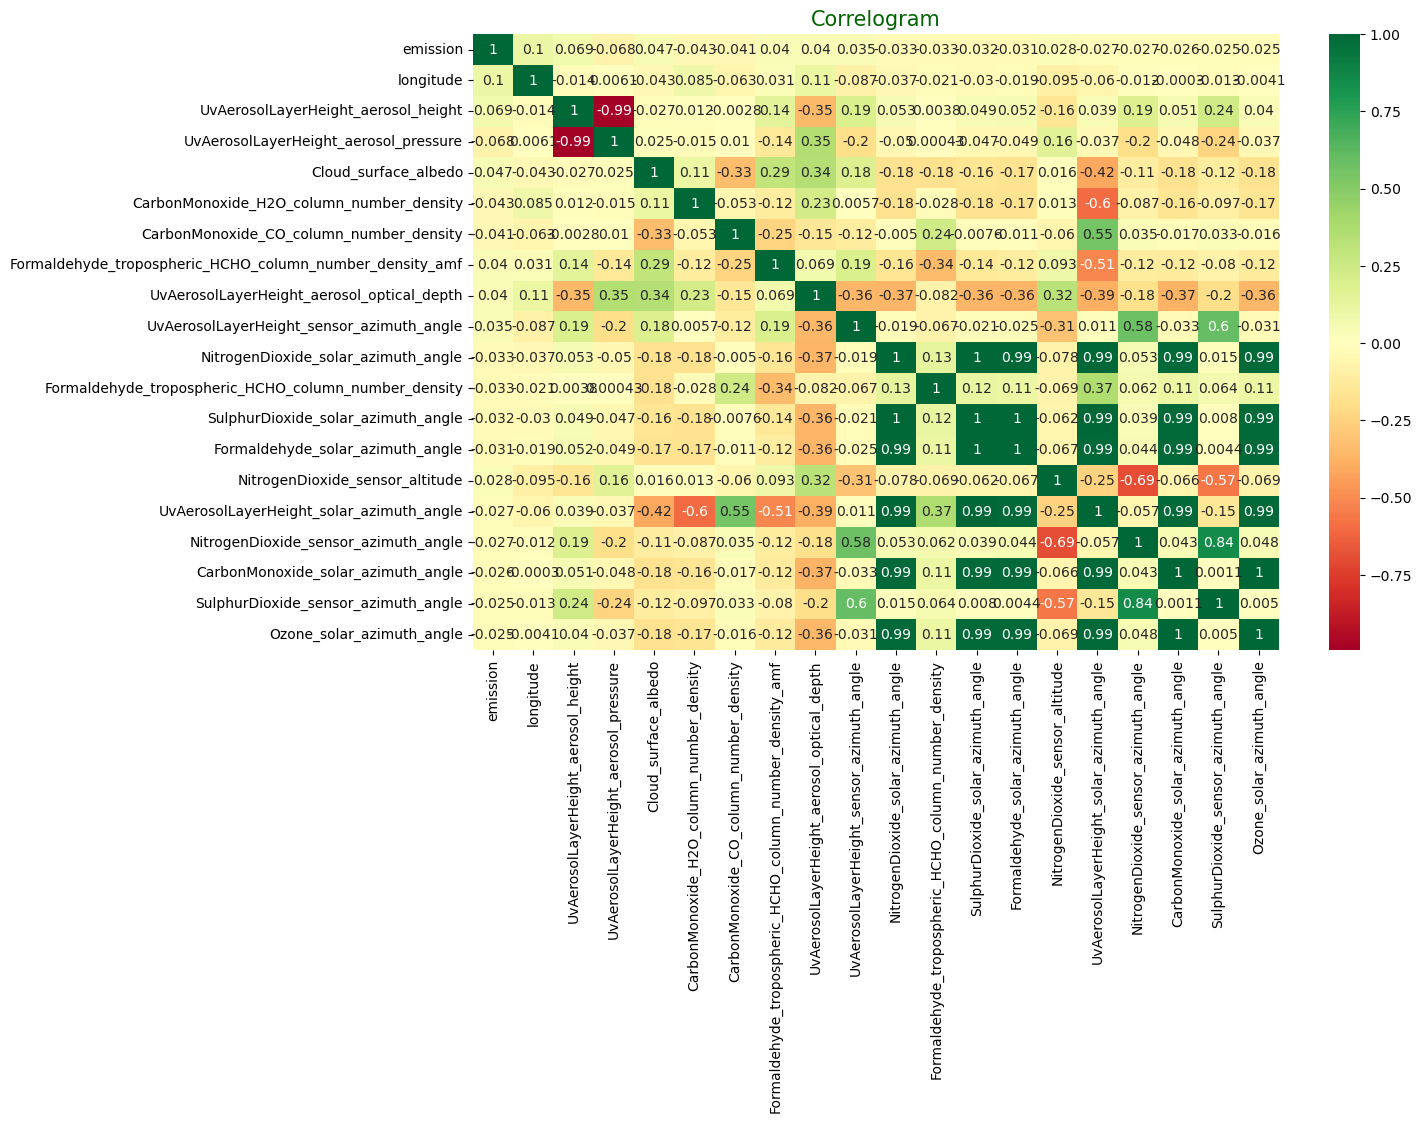

In [10]:
# Quantify correlations between features
corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

In [11]:
emission = trainset[['emission']]

In [12]:
emission.shape

(79023, 1)

In [13]:
SulphurDioxide = trainset.filter(regex = 'SulphurDioxide')   # 열이름에 SulphurDioxide(이산화황)가 포함된 열 출력
SulphurDioxide_Emission = pd.concat([SulphurDioxide, emission], axis = 1)

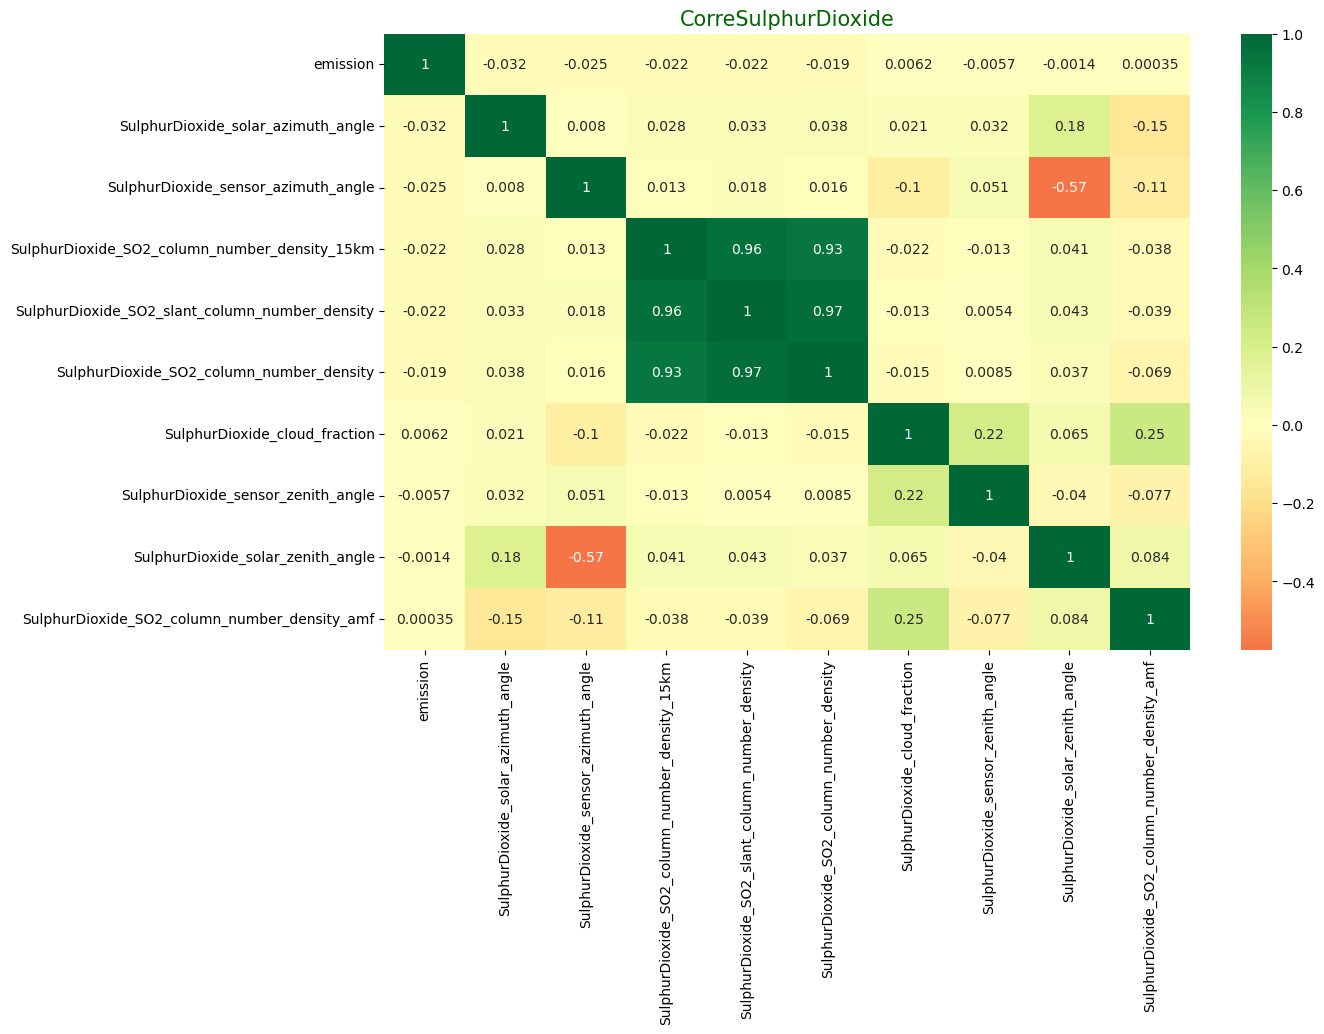

In [14]:
top20_corrs = abs(SulphurDioxide_Emission.corr()['emission']).sort_values(ascending = False).head(20)
corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('CorreSulphurDioxide', fontsize = 15, color = 'darkgreen')
plt.show()

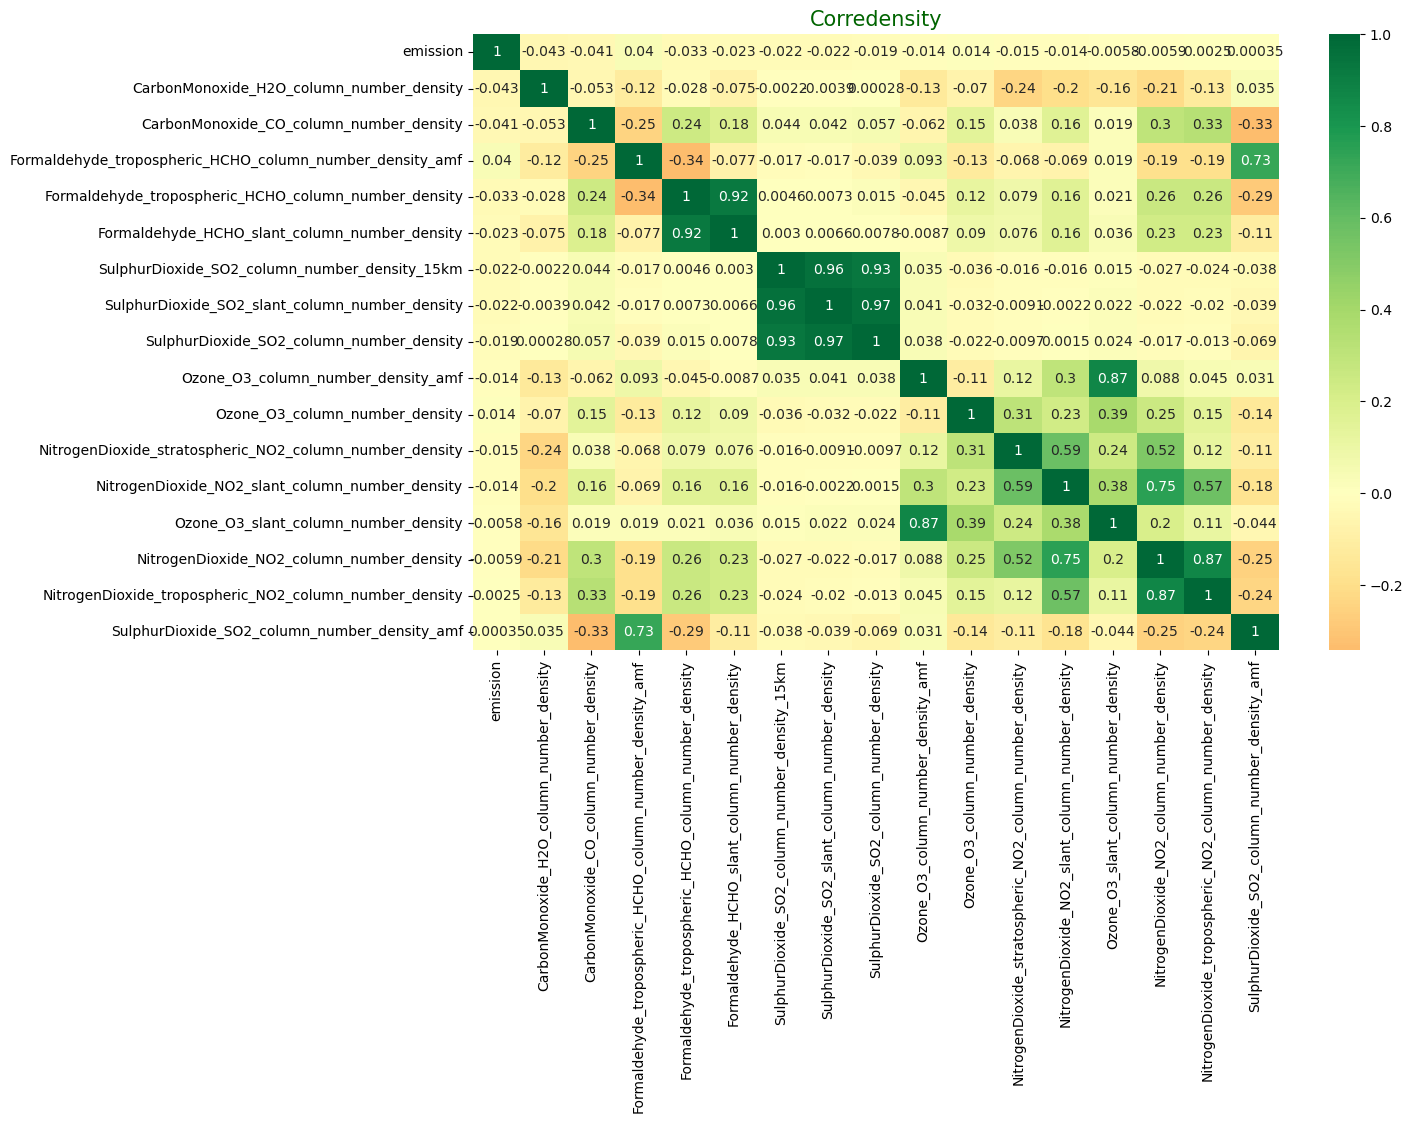

In [15]:
density = trainset.filter(regex = 'density')   # 열이름에 density(밀도)가 포함된 열 출력
density_Emission = pd.concat([density, emission], axis = 1)
top20_corrs = abs(density_Emission.corr()['emission']).sort_values(ascending = False).head(20)
corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Corredensity', fontsize = 15, color = 'darkgreen')
plt.show()

In [7]:
trainset_1500 = trainset['emission'] > 1500
trainset_2500 = trainset['emission'] < 2500
trainset_1500_2500 = trainset[trainset_1500 & trainset_2500 ]
trainset_1500_2500

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
46693,-2.079,29.321,2021,0,0.000024,0.809118,0.000019,0.161855,-12.441726,37.784299,-79.788767,28.178639,0.000007,0.032253,2035.418030,2852.535556,829941.610652,-12.337376,38.220766,-83.376035,28.171029,0.000044,0.000012,0.000031,0.000096,8613.720662,-1.868650,0.090985,830007.833333,-13.021288,36.952294,-81.628029,28.797087,0.000123,1.212767,0.000085,0.227673,28.324679,-81.292011,40.733671,-12.553946,-0.796929,830292.375000,-97.904343,61.830868,-126.136192,37.669579,0.116526,3.274206,0.385391,226.826477,0.978826,-97.904343,61.830868,-126.136192,37.669579,3273.519127,68663.265784,0.616453,30.888374,74.31282,-47.388756,27.043358,0.890866,44300.734375,6937.092529,50423.359375,5937.092773,10.172894,0.187399,-12.761456,60.347956,-138.794064,30.834650,2351.3560
56763,-2.378,29.222,2019,0,0.000024,0.809118,0.000019,0.161855,-12.441726,37.784299,-79.788767,28.178639,0.000007,0.029970,1760.160276,3437.016961,830142.951342,-12.427862,46.793419,-134.816079,31.314210,0.000044,0.000012,0.000031,0.000096,8613.720662,-1.868650,0.090985,830007.833333,-13.021288,36.952294,-81.628029,28.797087,-0.000034,1.001462,-0.000100,0.400168,38.623360,-124.682976,65.327873,-97.767784,-0.615869,830202.608165,-29.810083,41.569595,-134.412514,31.214853,0.117022,2.715110,0.322499,226.185935,0.721468,-29.810083,41.569595,-134.412514,31.214853,3273.519127,68663.265784,0.616453,30.888374,74.31282,-47.388756,27.043358,0.747583,55096.416016,3551.980225,62821.667969,2501.449463,17.740654,0.301972,-12.609234,19.539247,-135.

In [8]:
trainset_1500_2500['emission'] =  trainset_1500_2500['emission'].astype('int')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14652\3292592564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainset_1500_2500['emission'] =  trainset_1500_2500['emission'].astype('int')


In [18]:
trainset_1500_2500.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157 entries, 46693 to 56921
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   latitude                                                  157 non-null    float64
 1   longitude                                                 157 non-null    float64
 2   year                                                      157 non-null    int64  
 3   week_no                                                   157 non-null    int64  
 4   SulphurDioxide_SO2_column_number_density                  157 non-null    float64
 5   SulphurDioxide_SO2_column_number_density_amf              157 non-null    float64
 6   SulphurDioxide_SO2_slant_column_number_density            157 non-null    float64
 7   SulphurDioxide_cloud_fraction                             157 non-null    float64
 8   SulphurDioxide

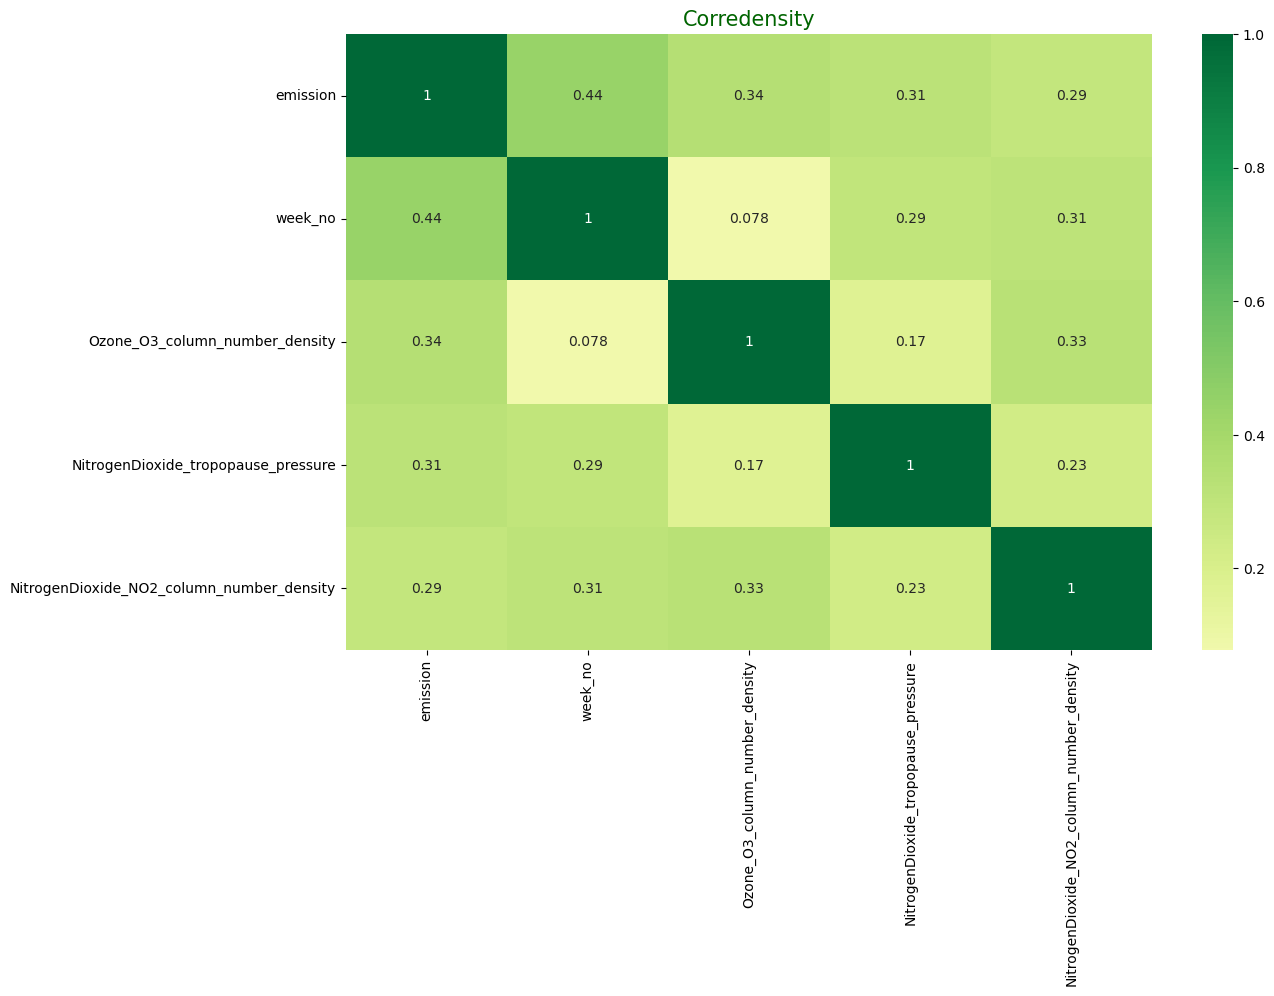

In [20]:
top5_corrs = abs(trainset_1500_2500.corr()['emission']).sort_values(ascending = False).head(5)
corr = trainset_1500_2500[list(top5_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Corredensity', fontsize = 15, color = 'darkgreen')
plt.show()

In [50]:
gmaps.geocode('Iburengerazuba')         #rwandaHigh.json 파일의 properties.name 중 하나

[{'address_components': [{'long_name': 'Western Province',
    'short_name': 'Western Province',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': 'Rwanda',
    'short_name': 'RW',
    'types': ['country', 'political']}],
  'formatted_address': 'Western Province, Rwanda',
  'geometry': {'bounds': {'northeast': {'lat': -1.5061628, 'lng': 29.6751738},
    'southwest': {'lat': -2.7441299, 'lng': 28.861754}},
   'location': {'lat': -2.07649, 'lng': 29.3250347},
   'location_type': 'APPROXIMATE',
   'viewport': {'northeast': {'lat': -1.5061628, 'lng': 29.6751738},
    'southwest': {'lat': -2.7441299, 'lng': 28.861754}}},
  'place_id': 'ChIJXYv3fhsd3RkR9XADsNpIi8A',
  'types': ['administrative_area_level_1', 'political']}]